In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import copy


In [30]:
def create_mnist_data(class_splits, split_index, csv_file="mnist.csv", image_shape=(1, 28, 28)):
    df = pd.read_csv(csv_file)
    all_classes = sorted(df['label'].unique())
    start_class = sum(class_splits[:split_index])
    end_class = start_class + class_splits[split_index]
    valid_classes = all_classes[start_class:end_class]

    filtered_df = df[df['label'].isin(valid_classes)]
    X = filtered_df.drop(columns=['label']).values
    y = filtered_df['label'].values
    label_mapping = {cls: i for i, cls in enumerate(valid_classes)}
    y = np.array([label_mapping[label] for label in y])

    X = torch.tensor(X / 255.0, dtype=torch.float32).view(-1, *image_shape)
    y = torch.tensor(y, dtype=torch.long)

    return TensorDataset(X, y)

In [31]:
def sample_finetune_data(dataset,new_label, samples_per_class=200):
    data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
    X, y = next(iter(data_loader))
    sampled_X, sampled_y = [], []

    for label in y.unique():
        indices = (y == label).nonzero(as_tuple=True)[0][:samples_per_class]
        sampled_X.append(X[indices])
        sampled_y.append(y[indices])

    sampled_X = torch.cat(sampled_X)
    sampled_y = torch.cat(sampled_y)
    sampled_y = torch.full_like(sampled_y, new_label)
    return TensorDataset(sampled_X, sampled_y)

In [32]:
def create_partial_group_data(finetune_sets):
    X, y = [], []
    for i, dataset in enumerate(finetune_sets):
        data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
        X_batch, y_batch = next(iter(data_loader))
        X.append(X_batch)
        y.append(torch.full_like(y_batch, i))

    X = torch.cat(X)
    y = torch.cat(y)
    return TensorDataset(X, y)


In [33]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [34]:
def train_model(model, data_loader, criterion, optimizer, epochs, device):
    """
    Trains a given model.
    """
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        with tqdm(total=len(data_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for X_batch, y_batch in data_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                pbar.set_postfix(loss=total_loss / (pbar.n + 1))
                pbar.update(1)



In [58]:
def inference_with_grouping(models, model_group, combined_loader, class_splits, index=None):
    """
    Performs inference using multiple models based on a grouping model.
    """
    all_preds = []
    all_labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_group.eval()
    for model in models:
        model.eval()

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(combined_loader):
            images, labels = images.to(device), labels.to(device)

            if len(images.shape) == 3:
                images = images.unsqueeze(1)

            # If index is provided, infer only that index
            if index is not None:
                images = images[index].unsqueeze(0)
                labels = labels[index].unsqueeze(0)

            # Determine which model to use
            group_logits = model_group(images)
            group_pred = torch.argmax(group_logits, dim=1)
            final_preds = []
            for i in range(images.shape[0]):
                model_idx = group_pred[i].item()
                model = models[model_idx]
                logits = model(images[i].unsqueeze(0))
                pred = torch.argmax(logits, dim=1).item()
                # print(f"Model {model_idx} prediction: {pred}")

                # Offset to match global label space
                offset = sum(class_splits[:model_idx])
                final_preds.append(pred + offset)

            all_preds.extend(final_preds)
            all_labels.extend(labels.cpu().numpy())

            if batch_idx % 2000 == 0 or index is not None:
                print(f"Batch {batch_idx} Predictions:")
                print(f"Predicted: {final_preds}")
                print(f"True:      {labels.cpu().numpy()}")

            if index is not None:
                break

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(sum(class_splits))))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(range(sum(class_splits))),
                yticklabels=list(range(sum(class_splits))))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(cm)



In [59]:
# --- Main Execution ---
class_splits = [2,2,2,2,2]
image_shape = (1, 28, 28)
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

models = []
data_loaders = []
replay_buffer = []

group_model = SimpleCNN(len(class_splits)).to(device)
optimizer_group = optim.Adam(group_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for i, num_classes in enumerate(class_splits):
    dataset = create_mnist_data(class_splits, i, image_shape=image_shape)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    data_loaders.append(loader)
    print(f"Training model {i} with {num_classes} classes")
    model = SimpleCNN(num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, loader, criterion, optimizer, epochs=3, device=device)
    models.append(model)

    group_data = sample_finetune_data(dataset,i,100)
    replay_buffer.extend(group_data)

print("replay size:",len(replay_buffer))
group_loader = DataLoader(replay_buffer, batch_size=batch_size,shuffle=True)
train_model(group_model, group_loader, criterion, optimizer_group, epochs=10, device=device)

print("\nTraining complete. Evaluating group model...")

Using device: cuda

Training model 0 with 2 classes


Epoch 3/3: 100%|██████████| 138/138 [00:00<00:00, 172.61batch/s, loss=0.00172]


Training model 1 with 2 classes


Epoch 3/3: 100%|██████████| 134/134 [00:00<00:00, 165.31batch/s, loss=0.0174]


Training model 2 with 2 classes


Epoch 3/3: 100%|██████████| 123/123 [00:00<00:00, 171.71batch/s, loss=0.00288]


Training model 3 with 2 classes


Epoch 3/3: 100%|██████████| 134/134 [00:00<00:00, 173.97batch/s, loss=0.000965]


Training model 4 with 2 classes


Epoch 3/3: 100%|██████████| 129/129 [00:00<00:00, 152.33batch/s, loss=0.0209]


replay size: 1000


Epoch 10/10: 100%|██████████| 16/16 [00:00<00:00, 231.86batch/s, loss=0.12]


Training complete. Evaluating group model...


Batch 0 Predictions:
Predicted: [1, 0, 1, 4, 0, 0, 7, 3, 5, 3, 8, 9, 1, 3, 3, 1, 8, 0, 7, 5, 8, 6, 2, 0, 2, 3, 6, 9, 9, 7, 8, 9, 4, 9, 7, 1, 3, 1, 1, 4, 9, 1, 4, 4, 2, 6, 3, 7, 7, 4, 7, 5, 1, 9, 0, 2, 2, 3, 9, 1, 2, 8, 5, 0]
True:      [1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 2 0 7 5 8 6 2 0 2 3 6 9 9 7 8 9 4 9 2 1 3
 1 1 4 9 1 4 4 2 6 3 7 7 4 7 5 1 9 0 2 2 3 9 1 1 1 5 0]

Overall Accuracy: 92.27%


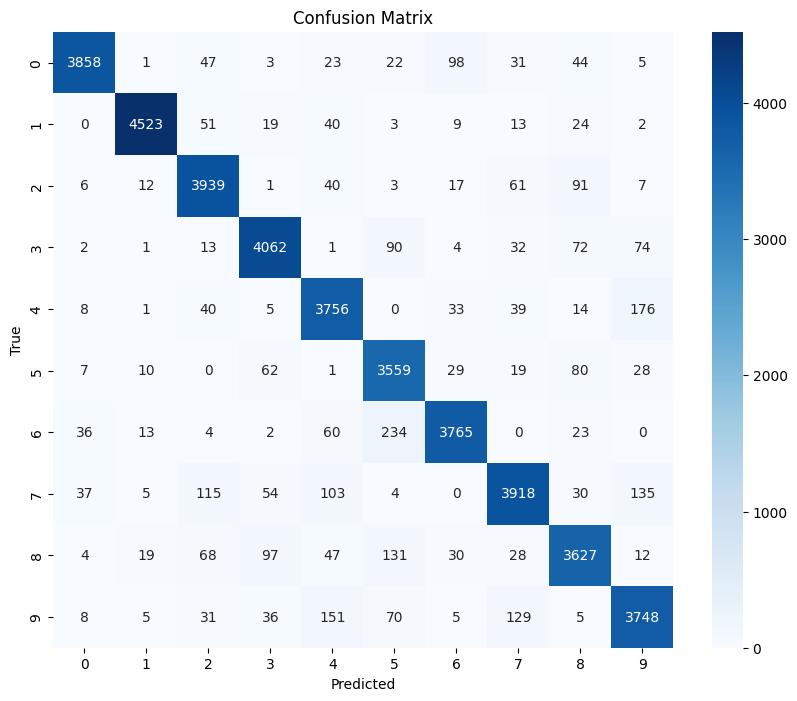

[[3858    1   47    3   23   22   98   31   44    5]
 [   0 4523   51   19   40    3    9   13   24    2]
 [   6   12 3939    1   40    3   17   61   91    7]
 [   2    1   13 4062    1   90    4   32   72   74]
 [   8    1   40    5 3756    0   33   39   14  176]
 [   7   10    0   62    1 3559   29   19   80   28]
 [  36   13    4    2   60  234 3765    0   23    0]
 [  37    5  115   54  103    4    0 3918   30  135]
 [   4   19   68   97   47  131   30   28 3627   12]
 [   8    5   31   36  151   70    5  129    5 3748]]


In [60]:
combined_loader = DataLoader(create_mnist_data([sum(class_splits)], 0, image_shape=image_shape), batch_size=batch_size)
inference_with_grouping(models, group_model, combined_loader, class_splits)
